#1. Install Dependencies and Setup

In [152]:
import tensorflow as tf    
import os
import cv2 
import imghdr # checks the file extensions of the images 
import numpy as np 
import matplotlib.pyplot as plt 

In [153]:

#Avoid OOM errors by setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

#2. Remove Dodgy Images

In [158]:
data_dir = 'data'

In [159]:
image_exts = ['jpeg','jpg','bmp','png']

In [160]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path) #opens up the image using opencv -- numpy array--bgr 
            ext = imghdr.what(image_path) #extracts the image extension
            if ext not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path) # delete the file 
        except Exception as e:
            print("Issue with image {}".format(image_path))
            

#3 Load Data

In [157]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 169 files belonging to 2 classes.


In [81]:
data_iterator = data.as_numpy_iterator()

In [82]:
#get another batch from the iterator
batch = data_iterator.next()
#Class-1 ---> SAD PEOPLE 
#Class-2 ---> HAPPY PEOPLE

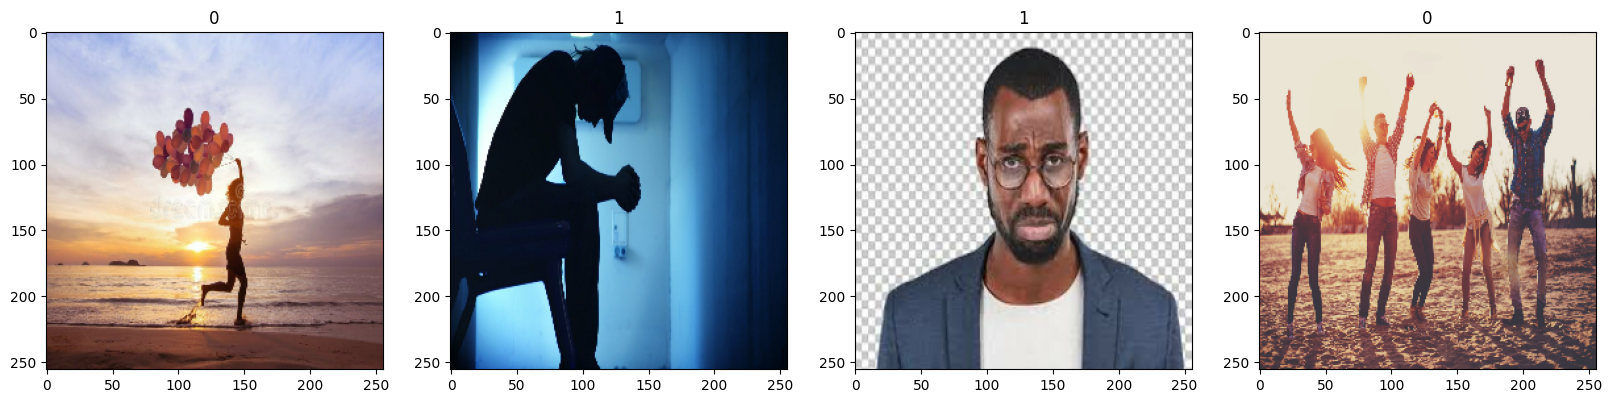

In [83]:
#To Check which label is assigned to which class 

fig,ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



#from the output 1-->sad , 0 --> happy people

#4. Scale Data

In [161]:
 #data transformation inside the pipeline
 scaled_data = data.map(lambda x,y : (x/255,y)) 

In [162]:
 scaled_iterator = scaled_data.as_numpy_iterator()

In [163]:
scaled_batch = scaled_iterator.next()

#5. Split Data

In [165]:
#len(data)---> no of batches 
train_size = int(len(scaled_data)*.7)  # train the deep learning model
val_size = int(len(scaled_data)*.2)    # evaluate the deep learning model while we training model
test_size = int(len(scaled_data)*.1)+1 # not going to see until the final evaluation state 

In [166]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test =scaled_data.skip(train_size + val_size).take(test_size)

#6. Build Deep Learning Model

In [168]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense, Flatten 


In [169]:
model = Sequential()

In [170]:
model.add(Conv2D(16,(3,3),1,activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [171]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [172]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 16)       

#7. Train

In [173]:
logdir = 'logs'

In [174]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [175]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 7s 1s/step - loss: 1.2710 - accuracy: 0.4531 - val_loss: 0.8197 - val_accuracy: 0.4062
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.7131 - accuracy: 0.5469 - val_loss: 0.6624 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.6424 - accuracy: 0.6328 - val_loss: 0.5719 - val_accuracy: 0.7812
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.6014 - accuracy: 0.6719 - val_loss: 0.5657 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.5141 - accuracy: 0.7578 - val_loss: 0.4220 - val_accuracy: 0.8125
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.4092 - accuracy: 0.8594 - val_loss: 0.3141 - val_accuracy: 0.9062
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3253 - accuracy: 0.8828 - val_loss: 0.2838 - val_accuracy: 0.8438
Epoch 8/20
4/4 [=========================

#8. Plot Performance

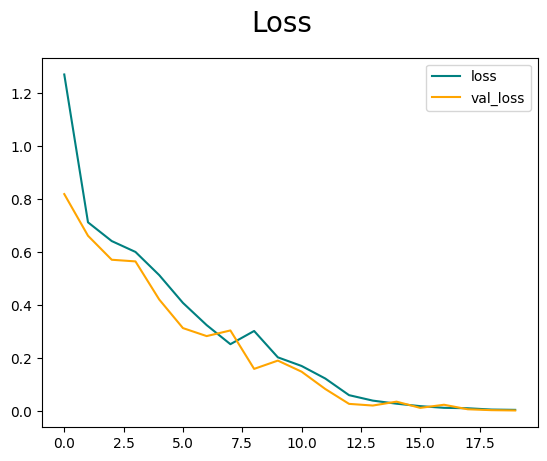

In [176]:
fig = plt.figure()
plt.plot(hist.history['loss'],color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper right')
plt.show()

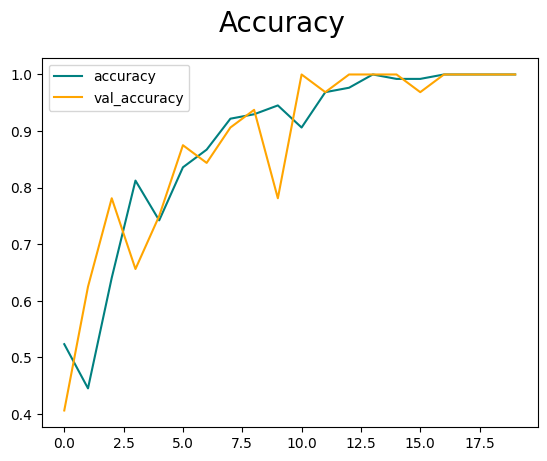

In [118]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

#9. Evaluate

In [119]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [120]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [132]:
for batch in test.as_numpy_iterator():
    x, y = batch 
    yhat = model.predict(x)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 123ms/step


In [134]:
print(f'Precision: {pre.result().numpy()}\nRecall: {re.result().numpy()}\nAccuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


#10. Test


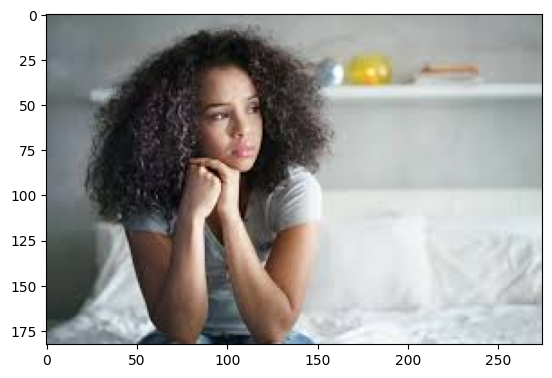

In [148]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

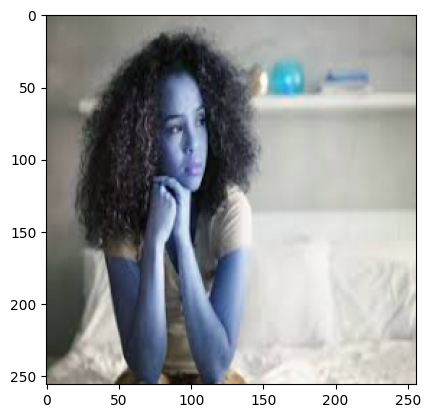

In [149]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [150]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 41ms/step


In [151]:
if yhat > 0.5:
    print(f'Predicted Class is Sad')
else:
    print(f'Predicted Class is Happy')

Predicted Class is Sad


#11. Save the Model

In [178]:
from tensorflow.keras.models import load_model

In [179]:
model.save(os.path.join('Models', 'imageclassification.h5'))

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [180]:
new_model = load_model(os.path.join('Models','imageclassification.h5'))

In [184]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 50ms/step


In [185]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
